In [2]:

from scipy.integrate import odeint
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve
from matplotlib import pyplot as plt, cm
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import solve_ivp
import numpy as np
from matplotlib.animation import FuncAnimation

#import jax.numpy as jnp

In [3]:
#set up grid
nx,ny = 200,200
x = np.linspace(0, nx, nx + 1)
y = np.linspace(0, ny, ny + 1)
X, Y = np.meshgrid(x, y)
L = 1
delta = L/nx


#charge density
rho = np.zeros([nx+1,ny+1],float)
rho[40:60,:] = 1e12* (1.6e-19) #C/m^2
epsilon = 8.85e-12 #F/m

#time steps
steps = 10
dt = 1e-8

#magnetic field
B = 0.1 #Tesla

In [ ]:
# trial 2: including periodic side boundary
def create_A(nx, ny):
    num_diag = (nx+1)*(ny-1)
    diag = np.full(num_diag, -4)
    lower = np.full((num_diag-1),1)
    upper = np.full((num_diag-1),1)
    identity = np.full(num_diag-(nx-1),1)
    side = np.full(ny-1,1)

    lower[nx-2::nx-1] = 0
    upper[nx-2::nx-1] = 0


    diagonal = [diag,lower,upper,identity,identity,side,side]
    offsets = [0,-1,1,-(nx-1),(nx-1),-nx*(ny-1),nx*(ny-1)]

    return diags(diagonal, offsets, shape =(num_diag, num_diag), format= 'csr')

#construct boundary vector B
def create_B(rho):
    lil_B2 = np.zeros(((nx+1)*(ny-1),1),float)
    f = rho[1:nx,0:ny+1].reshape((nx+1)*(ny-1),1,order = 'F')*delta**2/epsilon

    lil_B2[0:(nx+1)*(ny-1):(ny-1)] = -rho[0,0:nx+1].reshape((ny+1),1)
    lil_B2[ny-2:(nx+1)*(ny-1):(ny-1)] = -rho[ny,0:nx+1].reshape(ny+1,1)

    return lil_B2+f

def solve_poisson_1(rho):
    phi = np.zeros([nx+1,ny+1],float)
    A = create_A(nx,ny)
    B = create_B(rho)
    phi_flat = phi.flatten(order= 'F') 
    phi_flat= spsolve(A,B)
    phi[1:nx,0:ny+1] = phi_flat.reshape(nx-1,ny+1,order = 'F')
    return phi

In [5]:
def electric_field(phi):
    Ex = np.zeros([nx+1, ny+1], float)
    Ey = np.zeros([nx+1, ny+1], float)

    for i in range(1, nx):
        for j in range(1, ny):
            #row of an array is 'i' (y-direction)
            #column of an array is 'j' (x-direction)
            Ex[i, j] = -(phi[i, j + 1] - phi[i, j - 1]) / (2*delta)
            Ey[i, j] = -(phi[i + 1, j] - phi[i - 1, j]) / (2*delta)


    plt.show()
    return Ex, Ey

def velocity(Ex, Ey, B):
    vx = np.zeros([nx+1, ny+1], float)
    vy = np.zeros([nx+1, ny+1], float)

    for i in range(1, nx):
        for j in range(1, ny):
            vx[i, j] = Ey[i, j] / B
            vy[i, j] = -Ex[i, j] / B

    return vx, vy

#forward Euler method
def forward_euler_charge_density(rho, vx, vy, dt):
    #rho_new_time = rho.copy()
    for n in range(1):
        rho_new_time = rho.copy()
        for i in range(1, nx):
            for j in range(1, ny):
                # not sure vx and vy should be at i,j or i+1,j or i-1,j
                rho[i, j] = rho[i, j] - dt *( (rho_new_time[i +1, j]  - rho_new_time[i - 1, j] )* vy[i, j] /  (2*delta) +
                                                    (rho_new_time[i, j+1]  - rho_new_time[i, j - 1] ) * vx[i, j]/ (2*delta)  )
                #rho[i, j] = rho_new_time[i, j] - dt *( (rho_new_time[i, j]  - rho_new_time[i - 1, j] )* vy[i, j] /  (1*delta) +
                #                                   (rho_new_time[i, j]  - rho_new_time[i, j - 1] ) * vx[i, j]/ (1*delta)  )
                #rho_new_time[i, j] = rho[i, j] - dt * ( (rho[i , j] * vx[i, j] - rho[i - 1, j] * vx[i - 1, j]) /  delta +
                #                                    (rho[i, j] * vy[i, j] - rho[i, j - 1] * vy[i, j - 1]) / delta )
                rho[0,:] = 0
                rho[nx,:]=0
    return rho




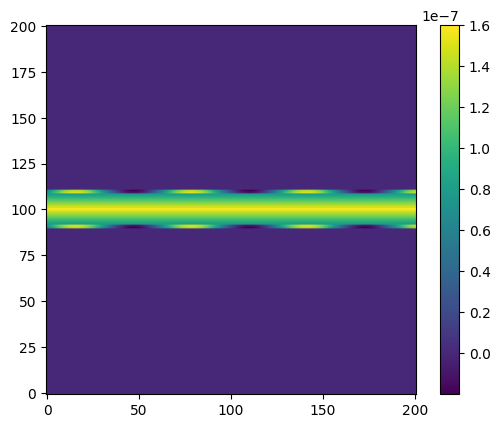

In [6]:
#initial charge density (Daisy)
rho = np.zeros([nx+1,ny+1],float)
rho[100,:]= 1e12* (1.6e-19) 
for i in range (101,111):
    for j in range (ny+1):
        rho[i,j] = rho[i-1,j]-1e-8

for i in range (99,89,-1):
    for j in range (ny+1):
        rho[i,j]= rho[i+1,j]-1e-8

#rho[80:110,:] = 1e12* (1.6e-19) #C/m^2
rho[109:111,:] += 0.8e-7 *np.sin(0.1*x)
rho[90:92,:] += 0.8e-7 *np.sin(0.1*x)
plt.imshow(rho, origin = 'lower')
plt.colorbar()


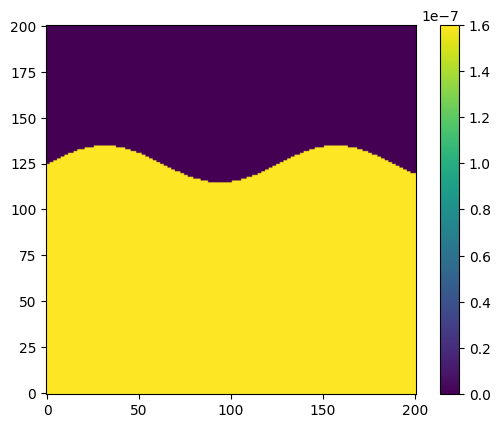

In [7]:
#initial charge density (Subin)
rho = np.zeros([nx+1,ny+1],float)
amplitude = 10
wave_number = 0.05
y_center = nx/2+25   
charge_density = 1e12* (1.6e-19) #C/m^2
#rho[0:110,:] = charge_density
perturbation = y_center + amplitude * np.sin(wave_number *x)

for i in range (nx+1):
    y_value = int(round(perturbation[i]))
    if (y_value>0):
        rho[0:y_value,i] = charge_density


plt.imshow(rho, origin = 'lower')
plt.colorbar()


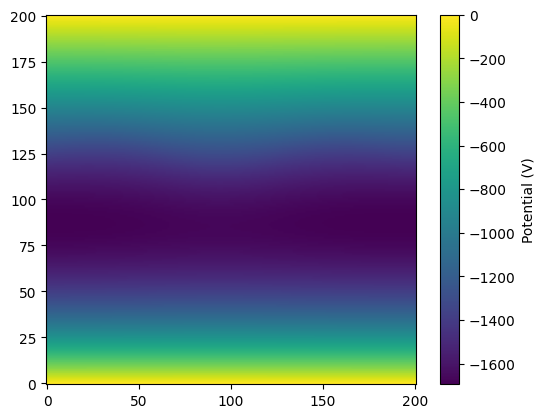

In [8]:
# solve Poisson equation with Matrix Inversion

phi = solve_poisson_1(rho)
plt.imshow(phi, origin = 'lower')
plt.colorbar(label="Potential (V)",shrink=1)
#ax.streamplot(X, Y, Ex, Ey, color="white", linewidth=1, cmap=plt.cm.inferno,
#              density=1.5, arrowstyle='->', arrowsize=1.5)


Ex, Ey = electric_field(phi)
vx, vy = velocity(Ex, Ey, B)
#plt.imshow(solve_rho_ode(vx,vy,rho), origin = 'lower')



In [9]:
# not sure if this is correct
def charge_density_ode(time_span, rho, vx, vy):
    rho= rho.reshape((nx+1, ny+1))
    dndt = np.zeros_like(rho)
    #dndt[0, :] = 0
    #dndt[nx, :] = 0
       
    for i in range(1, nx):
        for j in range(1, ny):
            dndt[i, j] = - ( (rho[i + 1, j]  - rho[i - 1, j] ) * vx[i , j]/ (2 * delta) +
                             (rho[i, j + 1]  - rho[i, j - 1] ) * vy[i, j ]/ (2 * delta) )
    return dndt.flatten()

def solve_rho_ode(vx,vy,rho):
    #vx, vy = velocity(Ex, Ey, B)
    time_span = (0.0, 0.01)
    time_intervals = np.linspace(0.0, 0.01,20)
    rho_0 = rho.flatten()
    sol = solve_ivp(charge_density_ode, time_span, rho_0, method='RK45', t_eval=time_intervals, args=(vx, vy))
    rho_new = sol.y[:,-1]
    return rho_new.reshape(nx+1, ny+1)

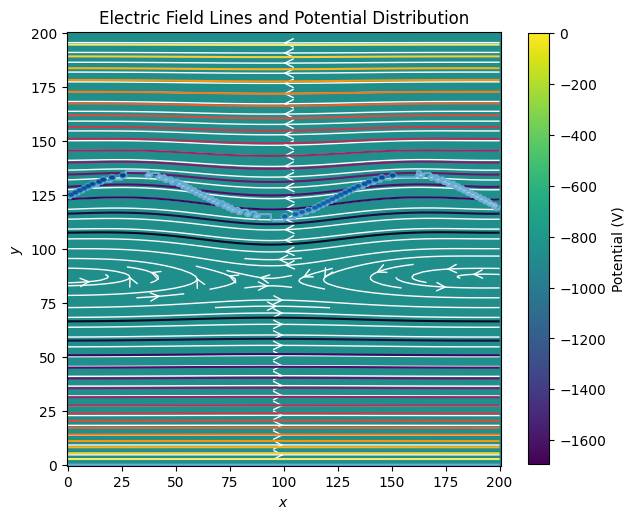

In [10]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.set_title('Electric Field Lines and Potential Distribution')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
dt = 1000

ax.streamplot(X, Y, vx, vy, color="white", linewidth=1, cmap=plt.cm.inferno,
              density=1.5, arrowstyle='->', arrowsize=1.5)
rho_new = forward_euler_charge_density(rho,vx,vy,dt)
plt.imshow(phi, origin='lower')
plt.colorbar(label="Potential (V)",shrink=0.8)

plt.contour(X, Y, phi, levels=20, cmap='inferno')
plt.contour(X, Y, rho, levels=20, cmap='Blues')
plt.imshow(rho_new, origin = 'lower')
plt.show()

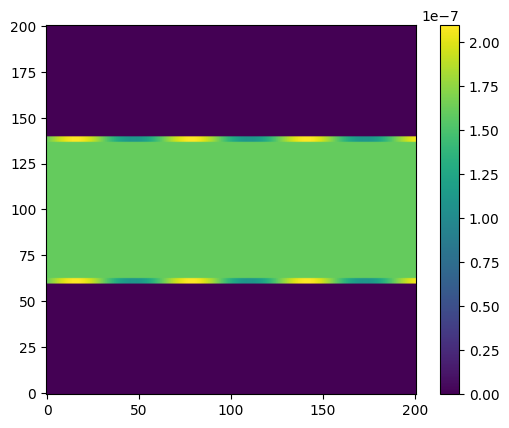

Time step 0
Total charge = 0.0025747112064381573
Time step 50
Total charge = 0.0025747102822384752
Time step 100
Total charge = 0.0025747084498174825
Time step 150
Total charge = 0.0025747057301571783
Time step 200
Total charge = 0.0025747021525884596
Time step 250
Total charge = 0.0025746977538765345
Time step 300
Total charge = 0.002574692577168076
Time step 350
Total charge = 0.002574686670863315
Time step 400
Total charge = 0.0025746800874760366
Time step 450
Total charge = 0.00257467288253963
Time step 500
Total charge = 0.002574665113608634
Time step 550
Total charge = 0.002574656839393532
Time step 600
Total charge = 0.0025746481190532106
Time step 650
Total charge = 0.002574639011655572
Time step 700
Total charge = 0.00257462957580364
Time step 750
Total charge = 0.002574619869413073
Time step 800
Total charge = 0.0025746099496181435
Time step 850
Total charge = 0.0025745998727774323
Time step 900
Total charge = 0.002574589694547903
Time step 950
Total charge = 0.00257457946999

MovieWriter imagemagick unavailable; using Pillow instead.


Saving animation... This may take a moment.


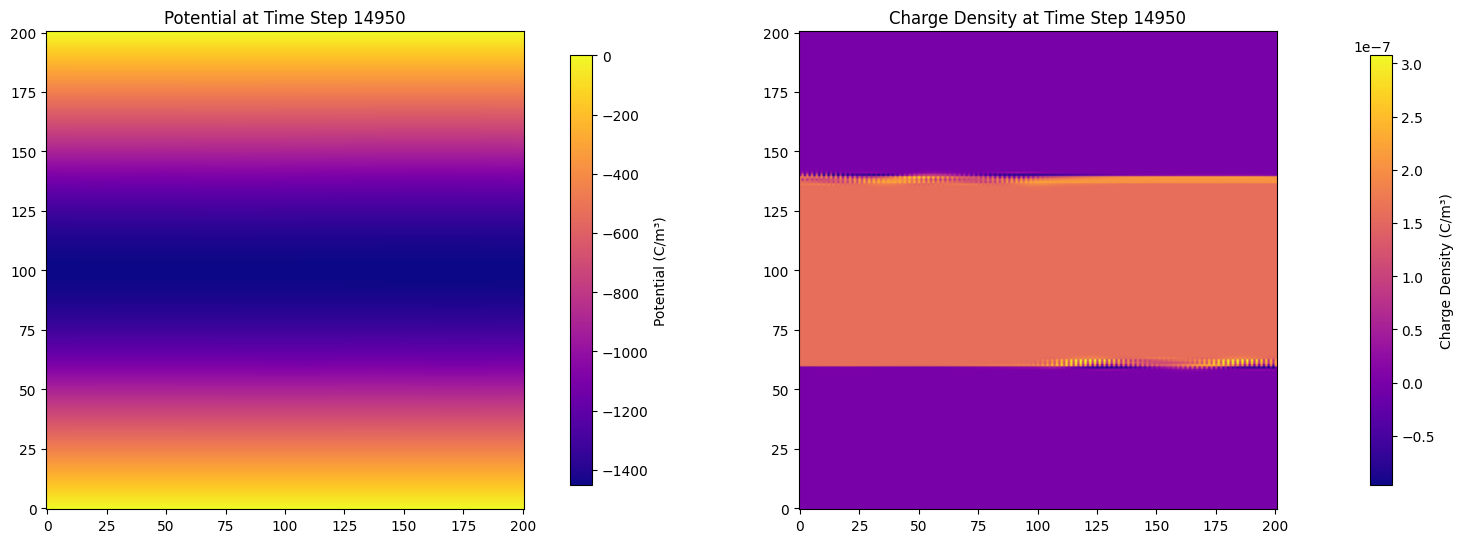

In [13]:
#run simulation
'''
rho = np.zeros([nx+1,ny+1],float)
rho[100,:]= 1e12* (1.6e-19) 
for i in range (101,111):
    for j in range (ny+1):
        rho[i,j] = rho[i-1,j]-1e-8

for i in range (99,89,-1):
    for j in range (ny+1):
        rho[i,j]= rho[i+1,j]-1e-8

#rho[80:110,:] = 1e12* (1.6e-19) #C/m^2
rho[110,:] += 0.16e-7 *np.sin(0.04*x)
rho[97,:] += 0.16e-7 *np.sin(0.04*x)
'''
rho = np.zeros([nx+1,ny+1],float)
rho[60:140,:]= 1e12* (1.6e-19) 
rho[137:140,:] += 0.5e-7 *np.sin(0.1*x)
rho[60:63,:] += 0.5e-7 *np.sin(0.1*x)

'''
rho = np.zeros([nx+1,ny+1],float)
amplitude = 3
wave_number = 0.04
y_center = nx/2+25   
charge_density = 1e12* (1.6e-19) #C/m^2
#rho[0:110,:] = charge_density
perturbation = y_center + amplitude * np.sin(wave_number *x)

for i in range (nx+1):
    y_value = int(round(perturbation[i]))
    if (y_value>0):
        rho[0:y_value,i] = charge_density
'''

dt = 1e-9
#plt.imshow(rho, origin = 'lower')
#plt.colorbar(label="Charge Density (C/m^2)",shrink=0.8)
history = []
frame_interval = 50
time_intervals = np.linspace(0, dt, 1)

plt.imshow(rho, origin = 'lower')
plt.colorbar()


step = 15000
for i in range (step):
    
    phi = solve_poisson_1(rho)
    Ex, Ey = electric_field(phi)
    vx, vy = velocity(Ex, Ey, B)
    rho_new = forward_euler_charge_density(rho,vx,vy,dt)
    #rho_new = fast_fourier_transform_rho(rho,vx,vy,dt)
    #rho_new = solve_rho_ode(vx,vy,rho)
    '''
    rho_flat = rho.flatten()
    sol = solve_ivp(charge_density_ode, (0,dt), rho_flat, method='RK45', t_eval=time_intervals, args=(vx, vy))
    rho_new_flat = sol.y[:,-1]
    rho = rho_new_flat.reshape(nx+1,ny+1)
    '''
    rho =  rho_new
    #rho = np.sum(rho_new)

    if i % frame_interval == 0:
        print(f"Time step {i}")
        print(f"Total charge = {np.sum(rho)}")
        history.append((rho.copy(), phi.copy(),i))
        
rho_initial, phi_initial,i = history[0]

fig = plt.figure(figsize=(19, 6))
ax1 = fig.add_subplot(1, 1, 1)
plot_1 = ax1.imshow(rho_initial, origin = 'lower',cmap = 'plasma')
plot_1_tiltle = ax1.set_title(f"Charge Density at Time Step {i}")
fig.colorbar(plot_1, ax=ax1, label='Charge Density (C/m³)', shrink=0.9)
        
ax2 = fig.add_subplot(1, 2, 1)
plot_2 = ax2.imshow(phi_initial, origin = 'lower',cmap = 'plasma')
plot_2_tiltle = ax2.set_title(f"Potential at Time Step {i}")
fig.colorbar(plot_2, ax=ax2, label='Potential (C/m³)', shrink=0.9)
        #ax2.streamplot(X, Y, Ex, Ey, color="white", linewidth=1, cmap=plt.cm.inferno,
         #     density=1.5, arrowstyle='->', arrowsize=1.5)

#plt.show()
plt.tight_layout()

def update(frame):
    rho_data, phi_data, step_num = history[frame]
    #scatter.set_offsets(np.vstack((nx, ny)).T)
    plot_1.set_data(rho_data)
    plot_2.set_data(phi_data)
    plot_1.set_clim(np.min(rho_data), np.max(rho_data))
    plot_2.set_clim(np.min(phi_data), np.max(phi_data))
    plot_1_tiltle.set_text((f"Charge Density at Time Step {step_num}"))
    plot_2_tiltle.set_text((f"Potential at Time Step {step_num}"))

    return plot_1, plot_2

ani = FuncAnimation(fig, update, frames=len(history), blit=True, interval=frame_interval)
print("Saving animation... This may take a moment.")
#ani.save('/Users/nganguyen/Downloads/capstone.gif', writer='imagemagick', fps=15)  
ani.save('test.gif', writer='imagemagick', fps=15)

plt.show()